In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy.stats import loguniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


In [3]:
df = pd.read_csv("twitter_bots_final.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37438 entries, 0 to 37437
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   default_profile              37438 non-null  bool   
 1   default_profile_image        37438 non-null  bool   
 2   description                  37438 non-null  object 
 3   favourites_count             37438 non-null  int64  
 4   followers_count              37438 non-null  int64  
 5   friends_count                37438 non-null  int64  
 6   geo_enabled                  37438 non-null  bool   
 7   lang                         37438 non-null  object 
 8   verified                     37438 non-null  bool   
 9   average_tweets_per_day       37438 non-null  float64
 10  account_age_days             37438 non-null  int64  
 11  account_type                 37438 non-null  object 
 12  word_count                   37438 non-null  int64  
 13  mean_word_length

In [5]:
df['account_type'].value_counts(normalize=True)

human    0.668118
bot      0.331882
Name: account_type, dtype: float64

In [ ]:
# drop unnecessary columns
df1 = df.drop(columns=['description_en', 'description'])

# define feature groups 
bool_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
cat_cols = ['lang', 'description_language']
num_cols = [
    'favourites_count', 'followers_count', 'friends_count',
    'average_tweets_per_day', 'account_age_days', 'word_count',
    'mean_word_length', 'hashtag_count', 'handle_count',
    'url_count', 'log_followers_friends_ratio'
]
target_col = 'account_type'

# convert target to binary
df1[target_col] = df1[target_col].map({'human': 0, 'bot': 1})

# split train/val/test 80/10/10
train_df1, temp_df1 = train_test_split(df1, test_size=0.2, stratify=df1[target_col], random_state=42)
val_df1, test_df1 = train_test_split(temp_df1, test_size=0.5, stratify=temp_df1[target_col], random_state=42)

print("Train:", train_df1.shape)
print("Val:", val_df1.shape)
print("Test:", test_df1.shape)

# boolean to int
train_df1[bool_cols] = train_df1[bool_cols].astype(int)
val_df1[bool_cols] = val_df1[bool_cols].astype(int)
test_df1[bool_cols] = test_df1[bool_cols].astype(int)

# one-hot encode categorical columns
train_df1 = pd.get_dummies(train_df1, columns=cat_cols, drop_first=True)

# ensure val/test have the same columns as train
val_df1 = pd.get_dummies(val_df1, columns=cat_cols, drop_first=True)
val_df1 = val_df1.reindex(columns=train_df1.columns, fill_value=0)

test_df1 = pd.get_dummies(test_df1, columns=cat_cols, drop_first=True)
test_df1 = test_df1.reindex(columns=train_df1.columns, fill_value=0)

# scale numerical features
scaler = StandardScaler()
train_df1[num_cols] = scaler.fit_transform(train_df1[num_cols])
val_df1[num_cols] = scaler.transform(val_df1[num_cols])
test_df1[num_cols] = scaler.transform(test_df1[num_cols])

# convert embeddings into arrays
def str_to_array(s):
    s = s.strip("[]")
    return np.array(s.split(), dtype=float)

train_df1['description_en_embeddings'] = train_df1['description_en_embeddings'].apply(str_to_array)
val_df1['description_en_embeddings'] = val_df1['description_en_embeddings'].apply(str_to_array)
test_df1['description_en_embeddings'] = test_df1['description_en_embeddings'].apply(str_to_array)

X_train_embed = np.vstack(train_df1['description_en_embeddings'].values)
X_val_embed   = np.vstack(val_df1['description_en_embeddings'].values)
X_test_embed  = np.vstack(test_df1['description_en_embeddings'].values)

# combine embeddings with tabular features
feature_cols = [c for c in train_df1.columns if c not in ['description_en_embeddings', target_col]]
X_train_tabular = train_df1[feature_cols].values
X_val_tabular   = val_df1[feature_cols].values
X_test_tabular  = test_df1[feature_cols].values

X_train = np.hstack([X_train_embed, X_train_tabular])
X_val   = np.hstack([X_val_embed, X_val_tabular])
X_test  = np.hstack([X_test_embed, X_test_tabular])

y_train = train_df1[target_col].values
y_val   = val_df1[target_col].values
y_test  = test_df1[target_col].values

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


Train: (29950, 19)
Val: (3744, 19)
Test: (3744, 19)
X_train shape: (29950, 576)
X_val shape: (3744, 576)
X_test shape: (3744, 576)


In [7]:
# check if there is contamination in the test set
train_df = pd.DataFrame(X_train)
test_df = pd.DataFrame(X_test)

# find overlaps / intersection between train and test sets
contaminated_samples = train_df.merge(test_df, how='inner')

if contaminated_samples.shape[0] > 0:
    print(f"Warning: {contaminated_samples.shape[0]} duplicate samples found in both train and test sets.")
else:
    print("No contamination detected.")

No contamination detected.


## Train all features without reducing dimensions

In [8]:
# define models
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, class_weight='balanced', random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=None, class_weight='balanced', random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=None, class_weight='balanced', random_state=42
    )
}

# train and evaluate
for name, model in models.items():
    print(f"\n===== {name} =====")
    
    # train
    model.fit(X_train, y_train)
    
    # validation
    y_val_pred = model.predict(X_val)
    y_val_prob = model.predict_proba(X_val)[:, 1]
    print("Validation Metrics:")
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("AUC:", roc_auc_score(y_val, y_val_prob))
    print(classification_report(y_val, y_val_pred))
    
    # test
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]
    print("Test Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("AUC:", roc_auc_score(y_test, y_test_prob))
    print(classification_report(y_test, y_test_pred))



===== Logistic Regression =====
Validation Metrics:
Accuracy: 0.7732371794871795
AUC: 0.8653436453254578
              precision    recall  f1-score   support

           0       0.89      0.75      0.82      2501
           1       0.62      0.81      0.70      1243

    accuracy                           0.77      3744
   macro avg       0.76      0.78      0.76      3744
weighted avg       0.80      0.77      0.78      3744

Test Metrics:
Accuracy: 0.7558760683760684
AUC: 0.8503461321120238
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      2502
           1       0.60      0.79      0.68      1242

    accuracy                           0.76      3744
   macro avg       0.74      0.76      0.74      3744
weighted avg       0.78      0.76      0.76      3744


===== Decision Tree =====
Validation Metrics:
Accuracy: 0.8221153846153846
AUC: 0.798869510924512
              precision    recall  f1-score   support

           0       

## Train features without embeddings

In [9]:
# define models
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, class_weight='balanced', random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=None, class_weight='balanced', random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=None, class_weight='balanced', random_state=42
    )
}

# train and evaluate
for name, model in models.items():
    print(f"\n===== {name} =====")
    
    # train
    model.fit(X_train_tabular, y_train)
    
    # validation
    y_val_pred = model.predict(X_val_tabular)
    y_val_prob = model.predict_proba(X_val_tabular)[:, 1]
    print("Validation Metrics:")
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("AUC:", roc_auc_score(y_val, y_val_prob))
    print(classification_report(y_val, y_val_pred))
    
    # test
    y_test_pred = model.predict(X_test_tabular)
    y_test_prob = model.predict_proba(X_test_tabular)[:, 1]
    print("Test Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("AUC:", roc_auc_score(y_test, y_test_prob))
    print(classification_report(y_test, y_test_pred))


===== Logistic Regression =====
Validation Metrics:
Accuracy: 0.7582799145299145
AUC: 0.8463800320579732
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      2501
           1       0.60      0.81      0.69      1243

    accuracy                           0.76      3744
   macro avg       0.74      0.77      0.75      3744
weighted avg       0.79      0.76      0.76      3744

Test Metrics:
Accuracy: 0.7438568376068376
AUC: 0.8350202285836388
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      2502
           1       0.58      0.81      0.68      1242

    accuracy                           0.74      3744
   macro avg       0.73      0.76      0.73      3744
weighted avg       0.78      0.74      0.75      3744


===== Decision Tree =====
Validation Metrics:
Accuracy: 0.8346688034188035
AUC: 0.8131217344116256
              precision    recall  f1-score   support

           0      

## Use model1 to reduce embeddings into a probability score

In [10]:
# use logreg for model1
model1 = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight to handle imbalance
model1.fit(X_train_embed, y_train)

# predict probabilities
train_prob = model1.predict_proba(X_train_embed)[:, 1]
val_prob   = model1.predict_proba(X_val_embed)[:, 1]
test_prob  = model1.predict_proba(X_test_embed)[:, 1]

# check performance on validation set
y_val_pred = model1.predict(X_val_embed)
y_val_prob = val_prob

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation AUC:", roc_auc_score(y_val, y_val_prob))
print(classification_report(y_val, y_val_pred))

# add model1 probability as a new column to your tabular features
X_train_model2 = np.hstack([train_prob.reshape(-1, 1), X_train_tabular])
X_val_model2   = np.hstack([val_prob.reshape(-1, 1), X_val_tabular])
X_test_model2  = np.hstack([test_prob.reshape(-1, 1), X_test_tabular])

print("X_train_model2 shape:", X_train_model2.shape)
print("X_val_model2 shape:", X_val_model2.shape)
print("X_test_model2 shape:", X_test_model2.shape)

Validation Accuracy: 0.6728098290598291
Validation AUC: 0.7587108358587378
              precision    recall  f1-score   support

           0       0.85      0.62      0.72      2501
           1       0.50      0.79      0.61      1243

    accuracy                           0.67      3744
   macro avg       0.68      0.70      0.67      3744
weighted avg       0.74      0.67      0.68      3744

X_train_model2 shape: (29950, 193)
X_val_model2 shape: (3744, 193)
X_test_model2 shape: (3744, 193)


try rf for model1

In [11]:
# use randomforest for model1
model1_tree = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=None,          # no limit on depth; you can tune this
    class_weight='balanced', # handle class imbalance
    random_state=42
)

# train on embeddings
model1_tree.fit(X_train_embed, y_train)

# predict probabilities
train_prob_tree = model1_tree.predict_proba(X_train_embed)[:, 1]
val_prob_tree   = model1_tree.predict_proba(X_val_embed)[:, 1]
test_prob_tree  = model1_tree.predict_proba(X_test_embed)[:, 1]

# evaluate on validation set 
y_val_pred_tree = model1_tree.predict(X_val_embed)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_tree))
print("Validation AUC:", roc_auc_score(y_val, val_prob_tree))
print(classification_report(y_val, y_val_pred_tree))

# combine probability scores with tabular features for model2
X_train_model2_tree = np.hstack([train_prob_tree.reshape(-1, 1), X_train_tabular])
X_val_model2_tree   = np.hstack([val_prob_tree.reshape(-1, 1), X_val_tabular])
X_test_model2_tree  = np.hstack([test_prob_tree.reshape(-1, 1), X_test_tabular])

print("X_train_model2_tree shape:", X_train_model2_tree.shape)

Validation Accuracy: 0.6917735042735043
Validation AUC: 0.7448623125166667
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      2501
           1       0.53      0.62      0.57      1243

    accuracy                           0.69      3744
   macro avg       0.66      0.67      0.67      3744
weighted avg       0.71      0.69      0.70      3744

X_train_model2_tree shape: (29950, 193)


performance dont seem as good as lr

model2 = logistic regression

In [12]:
# initialise model2 using logistic regression
model2_lr = LogisticRegression(max_iter=1000, class_weight='balanced')

# train on training set
model2_lr.fit(X_train_model2, y_train)

# predict on validation
y_val_pred = model2_lr.predict(X_val_model2)
y_val_prob = model2_lr.predict_proba(X_val_model2)[:, 1]

# evaluate
print("LR Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("LR Validation ROC-AUC:", roc_auc_score(y_val, y_val_prob))
print(classification_report(y_val, y_val_pred))


LR Validation Accuracy: 0.7777777777777778
LR Validation ROC-AUC: 0.8648196393204584
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      2501
           1       0.63      0.81      0.71      1243

    accuracy                           0.78      3744
   macro avg       0.76      0.79      0.76      3744
weighted avg       0.80      0.78      0.78      3744



In [13]:
# predict on test set
y_test_pred = model2_lr.predict(X_test_model2)
y_test_prob = model2_lr.predict_proba(X_test_model2)[:, 1]

print("LR Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("LR Test AUC:", roc_auc_score(y_test, y_test_prob))
print(classification_report(y_test, y_test_pred))


LR Test Accuracy: 0.7540064102564102
LR Test AUC: 0.847362045951001
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      2502
           1       0.60      0.78      0.68      1242

    accuracy                           0.75      3744
   macro avg       0.74      0.76      0.74      3744
weighted avg       0.78      0.75      0.76      3744



model2 = decision tree

In [14]:
# initialise model2 using decision tree
model2_dt = DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=42)
model2_dt.fit(X_train_model2, y_train)

# predict on validation set 
y_val_pred = model2_dt.predict(X_val_model2)
y_val_prob = model2_dt.predict_proba(X_val_model2)[:, 1]

print("DT Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("DT Validation ROC-AUC:", roc_auc_score(y_val, y_val_prob))
print(classification_report(y_val, y_val_pred))


DT Validation Accuracy: 0.8330662393162394
DT Validation ROC-AUC: 0.8101012209758092
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2501
           1       0.75      0.74      0.75      1243

    accuracy                           0.83      3744
   macro avg       0.81      0.81      0.81      3744
weighted avg       0.83      0.83      0.83      3744



In [15]:
# predict on test set 
y_test_pred = model2_dt.predict(X_test_model2)
y_test_prob = model2_dt.predict_proba(X_test_model2)[:, 1]

print("DT Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("DT Test ROC-AUC:", roc_auc_score(y_test, y_test_prob))
print(classification_report(y_test, y_test_pred))


DT Test Accuracy: 0.8207799145299145
DT Test ROC-AUC: 0.7939358658001135
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2502
           1       0.74      0.71      0.73      1242

    accuracy                           0.82      3744
   macro avg       0.80      0.79      0.80      3744
weighted avg       0.82      0.82      0.82      3744



model2 = random forest 

In [16]:
# initialise model2 using random forest
model2_rf = RandomForestClassifier(n_estimators=200, max_depth=None, class_weight='balanced', random_state=42)
model2_rf.fit(X_train_model2, y_train)

# predict on validation set 
y_val_pred = model2_rf.predict(X_val_model2)
y_val_prob = model2_rf.predict_proba(X_val_model2)[:, 1]

print("RF Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("RF Validation ROC-AUC:", roc_auc_score(y_val, y_val_prob))
print(classification_report(y_val, y_val_pred))


RF Validation Accuracy: 0.8784722222222222
RF Validation ROC-AUC: 0.9371241045014014
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2501
           1       0.88      0.74      0.80      1243

    accuracy                           0.88      3744
   macro avg       0.88      0.84      0.86      3744
weighted avg       0.88      0.88      0.88      3744



In [17]:
# predict on test set
y_test_pred = model2_rf.predict(X_test_model2)
y_test_prob = model2_rf.predict_proba(X_test_model2)[:, 1]

print("RF Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("RF Test ROC-AUC:", roc_auc_score(y_test, y_test_prob))
print(classification_report(y_test, y_test_pred))


RF Test Accuracy: 0.8656517094017094
RF Test ROC-AUC: 0.9289064722457139
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2502
           1       0.85      0.72      0.78      1242

    accuracy                           0.87      3744
   macro avg       0.86      0.83      0.84      3744
weighted avg       0.86      0.87      0.86      3744



## BERTopic

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
import umap
import matplotlib.pyplot as plt
import shap


In [19]:
# Count empty or missing description_en
empty_count = df['description_en'].isna().sum() + (df['description_en'].str.strip() == '').sum()

print(f"Number of empty or missing descriptions: {empty_count}")
print(f"Percentage of total: {empty_count / len(df) * 100:.2f}%")


Number of empty or missing descriptions: 13341
Percentage of total: 35.63%


Empty descriptions: 13341
Percentage of total: 35.63%


Python(11891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Python(11892) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Python(11893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forke


Train Topic Proportions (%):
-1     32.23
 0     35.80
 1      4.62
 2      4.43
 3      4.09
 4      2.74
 5      2.62
 6      2.23
 7      2.21
 8      1.99
 9      1.65
 10     1.20
 11     0.97
 12     0.88
 13     0.64
 14     0.35
 15     0.28
 16     0.22
 17     0.22
 18     0.17
 19     0.11
 20     0.10
 21     0.10
 22     0.09
 23     0.05
Name: topic, dtype: float64


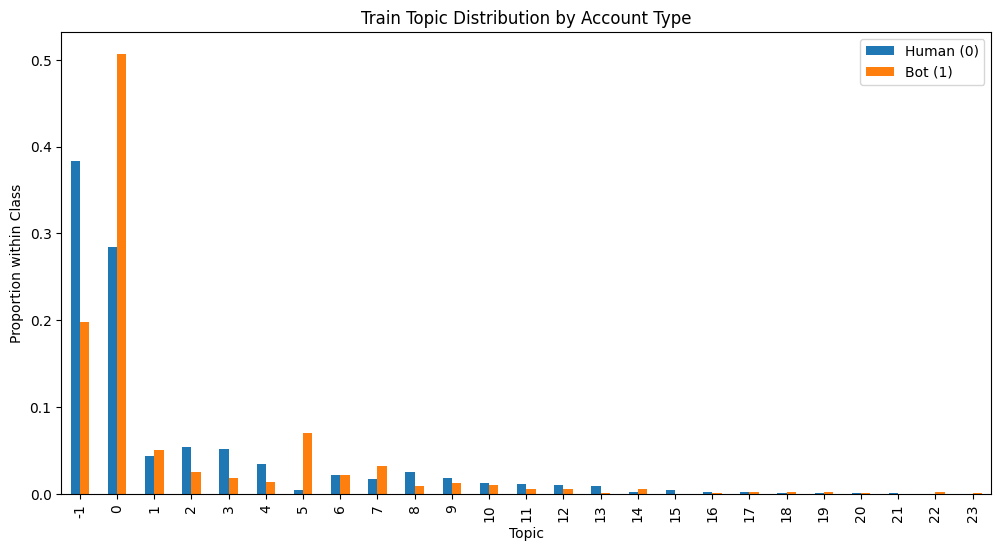


Top Topics:
   Topic  Count                                               Name  \
0     -1   9652                                -1_love_life_im_mom   
1      0  10722  0_missing_description_missing_description miss...   
2      1   1383                       1_twitter_bot_tweet_official   
3      2   1328                2_translationtext_im_im sorry_sorry   
4      3   1224                        3_music_writer_actress_book   
5      4    820                4_husband_father_husband father_dad   
6      5    784                              5_come_like_want_site   
7      6    668                     6_love_life_dream_harshly come   
8      7    661          7_trading_stock_day trading_trading stock   
9      8    597                  8_news_journalist_reporter_editor   

                                      Representation  \
0  [love, life, im, mom, lover, world, fan, write...   
1  [missing_description, missing_description miss...   
2  [twitter, bot, tweet, official, account, offi

In [55]:
# drop unused columns 
df_bert = df.drop(columns=['description', 'description_en_embeddings']).copy()

# check empty descriptions
empty_count = df_bert['description_en'].isna().sum()
print(f"Empty descriptions: {empty_count}")
print(f"Percentage of total: {empty_count / len(df) * 100:.2f}%")

# replace empty descriptions with placeholder
df_bert['description_en'] = df_bert['description_en'].fillna("missing_description")

# convert to binary
df_bert['account_type'] = df_bert['account_type'].map({'bot': 1, 'human': 0})

# train/val/test 80/10/10
train_df, temp_df = train_test_split(df_bert, test_size=0.2, stratify=df_bert['account_type'], random_state=42)
val_df, test_df  = train_test_split(temp_df, test_size=0.5, stratify=temp_df['account_type'], random_state=42)

# tabular features
bool_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
cat_cols  = ['lang', 'description_language']
num_cols  = [
    'favourites_count', 'followers_count', 'friends_count',
    'average_tweets_per_day', 'account_age_days', 'word_count',
    'mean_word_length', 'hashtag_count', 'handle_count',
    'url_count', 'log_followers_friends_ratio'
]

# booleans to int
for col in bool_cols:
    train_df[col] = train_df[col].astype(int)
    val_df[col]   = val_df[col].astype(int)
    test_df[col]  = test_df[col].astype(int)

# one-hot encode categoricals
train_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=False)
val_df   = pd.get_dummies(val_df, columns=cat_cols, drop_first=False)
val_df   = val_df.reindex(columns=train_df.columns, fill_value=0)
test_df  = pd.get_dummies(test_df, columns=cat_cols, drop_first=False)
test_df  = test_df.reindex(columns=train_df.columns, fill_value=0)

# scale numeric features
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
val_df[num_cols]   = scaler.transform(val_df[num_cols])
test_df[num_cols]  = scaler.transform(test_df[num_cols])

# define BERTopic model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # English

umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=10,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

vectorizer_model = CountVectorizer(ngram_range=(1,3), stop_words='english')

nr_topics = 25

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    language="english",
    nr_topics=nr_topics,
    top_n_words=10
)

# fit BERTopic model on train set 
train_texts = train_df['description_en'].tolist()
topics_train, probs_train = topic_model.fit_transform(train_texts)

# transform val and test
val_texts  = val_df['description_en'].tolist()
topics_val, probs_val = topic_model.transform(val_texts)

test_texts  = test_df['description_en'].tolist()
topics_test, probs_test = topic_model.transform(test_texts)

# add topics to DataFrames
train_df['topic'] = topics_train
val_df['topic']   = topics_val
test_df['topic']  = topics_test

# visualise performance
topic_counts = train_df['topic'].value_counts(normalize=True).sort_index()
print("\nTrain Topic Proportions (%):")
print((topic_counts*100).round(2))

# topic proportions by account_type
topic_by_label = train_df.groupby(['account_type','topic']).size().unstack(fill_value=0)
topic_by_label = topic_by_label.div(topic_by_label.sum(axis=1), axis=0)
topic_by_label.T.plot(kind="bar", figsize=(12,6))
plt.title("Train Topic Distribution by Account Type")
plt.ylabel("Proportion within Class")
plt.xlabel("Topic")
plt.legend([f"{label} ({i})" for i, label in enumerate(["Human", "Bot"])])
plt.show()

# look at top topics
topic_info = topic_model.get_topic_info()
print("\nTop Topics:")
print(topic_info.head(10))

# example: topic 3 words
print("\nExample Topic 3 Words:")
print(topic_model.get_topic(3))

# create feature matrices 

# one-hot encode topics
topic_dummies_train = pd.get_dummies(train_df['topic'].astype(str), prefix='topic')
topic_dummies_val   = pd.get_dummies(val_df['topic'].astype(str), prefix='topic')
topic_dummies_test  = pd.get_dummies(test_df['topic'].astype(str), prefix='topic')

# align columns
topic_dummies_val  = topic_dummies_val.reindex(columns=topic_dummies_train.columns, fill_value=0)
topic_dummies_test = topic_dummies_test.reindex(columns=topic_dummies_train.columns, fill_value=0)

# tabular features
tabular_cols = [c for c in train_df.columns if c not in ['description_en', 'topic', 'account_type']]

X_train_bert = np.hstack([topic_dummies_train.values, train_df[tabular_cols].values])
X_val_bert   = np.hstack([topic_dummies_val.values, val_df[tabular_cols].values])
X_test_bert  = np.hstack([topic_dummies_test.values, test_df[tabular_cols].values])

y_train_bert = train_df['account_type'].values
y_val_bert   = val_df['account_type'].values
y_test_bert  = test_df['account_type'].values

print("X_train_bert shape:", X_train_bert.shape)
print("X_val_bert shape:", X_val_bert.shape)
print("X_test_bert shape:", X_test_bert.shape)

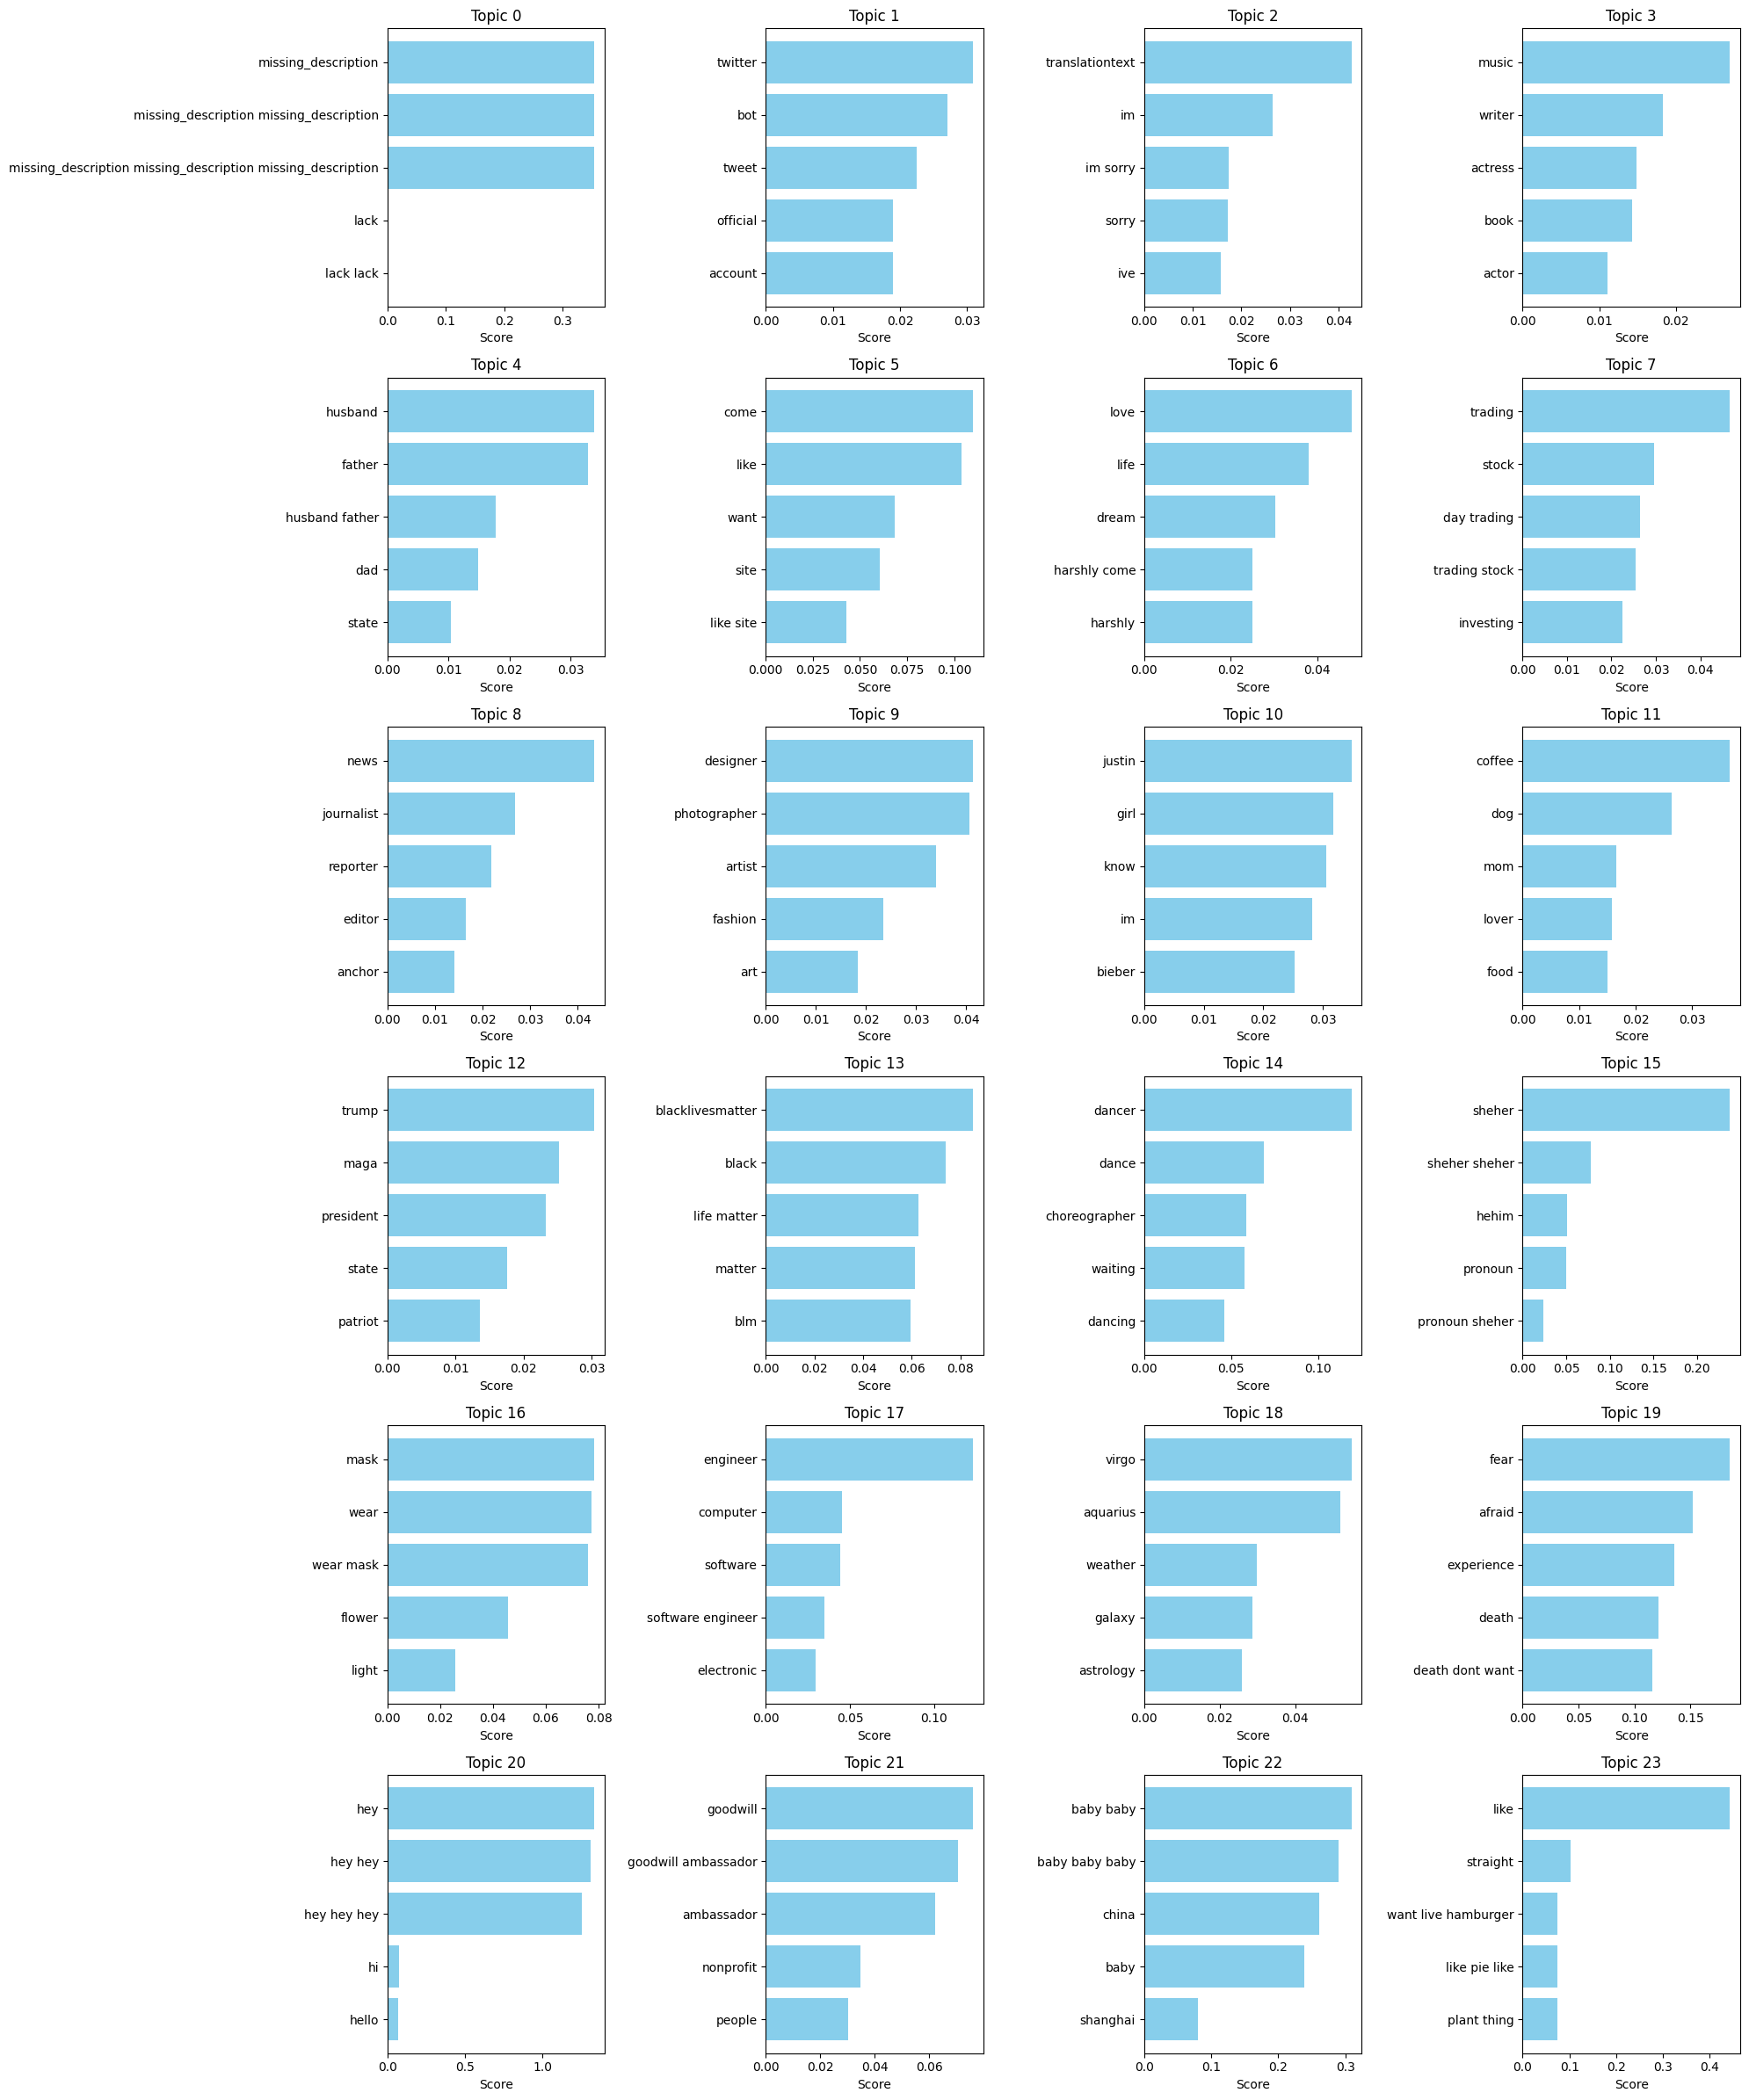

In [56]:
import math

top_n_words = 5  # number of top words to show
topics = topic_model.get_topics()
topics_to_plot = [tid for tid in topics.keys() if tid != -1]  # skip -1

# grid size: 4 plots per row
n_cols = 4
n_rows = math.ceil(len(topics_to_plot) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  # flatten in case of multiple rows

for i, topic_id in enumerate(topics_to_plot):
    words_scores = topics[topic_id][:top_n_words]
    words, scores = zip(*words_scores)
    axes[i].barh(words, scores, color='skyblue')
    axes[i].set_title(f"Topic {topic_id}")
    axes[i].invert_yaxis()  # highest score on top
    axes[i].set_xlabel("Score")

# hide any unused subplots if number of topics is not divisible by n_cols
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [57]:
# check if there is contamination in the test set
train_df = pd.DataFrame(X_train_bert)
test_df = pd.DataFrame(X_test_bert)

# find overlaps / intersection between train and test sets
contaminated_samples = train_df.merge(test_df, how='inner')

if contaminated_samples.shape[0] > 0:
    print(f"Warning: {contaminated_samples.shape[0]} duplicate samples found in both train and test sets.")
else:
    print("No contamination detected.")

No contamination detected.


In [58]:
# convert to DataFrames for comparison
train_check = pd.DataFrame(X_train_bert)
test_check = pd.DataFrame(X_test_bert)

# find overlapping rows
overlap = pd.merge(train_check, test_check, how='inner')

if len(overlap) > 0:
    print(f"{len(overlap)} overlapping samples found between train and test sets!")
else:
    print("No overlap detected between train and test sets.")

No overlap detected between train and test sets.


In [59]:
lr_bert = LogisticRegression(max_iter=1000, class_weight='balanced')

# train on training set
lr_bert.fit(X_train_bert, y_train_bert)

# predict on validation
y_val_pred = lr_bert.predict(X_val_bert)
y_val_prob = lr_bert.predict_proba(X_val_bert)[:, 1]

# evaluate
print("LR Validation Accuracy:", accuracy_score(y_val_bert, y_val_pred))
print("LR Validation ROC-AUC:", roc_auc_score(y_val_bert, y_val_prob))
print(classification_report(y_val_bert, y_val_pred))

LR Validation Accuracy: 0.7609508547008547
LR Validation ROC-AUC: 0.8505698283840125
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      2501
           1       0.61      0.79      0.69      1243

    accuracy                           0.76      3744
   macro avg       0.74      0.77      0.75      3744
weighted avg       0.79      0.76      0.77      3744



In [60]:
# predict on test set
y_test_pred = lr_bert.predict(X_test_bert)
y_test_prob = lr_bert.predict_proba(X_test_bert)[:, 1]

print("LR Test Accuracy:", accuracy_score(y_test_bert, y_test_pred))
print("LR Test AUC:", roc_auc_score(y_test_bert, y_test_prob))
print(classification_report(y_test_bert, y_test_pred))

LR Test Accuracy: 0.7377136752136753
LR Test AUC: 0.8389906432342049
              precision    recall  f1-score   support

           0       0.87      0.71      0.78      2502
           1       0.58      0.79      0.67      1242

    accuracy                           0.74      3744
   macro avg       0.72      0.75      0.72      3744
weighted avg       0.77      0.74      0.74      3744



Top features for Logistic Regression:
       feature  importance
31    verified    2.432348
20     topic_5    2.150194
65     lang_mk    1.895817
8     topic_15    1.842936
87  lang_zh-cn    1.816042
73     lang_ru    1.526392
6     topic_13    1.425188
62     lang_ko    1.326033
58     lang_hu    1.303130
16    topic_22    1.216515


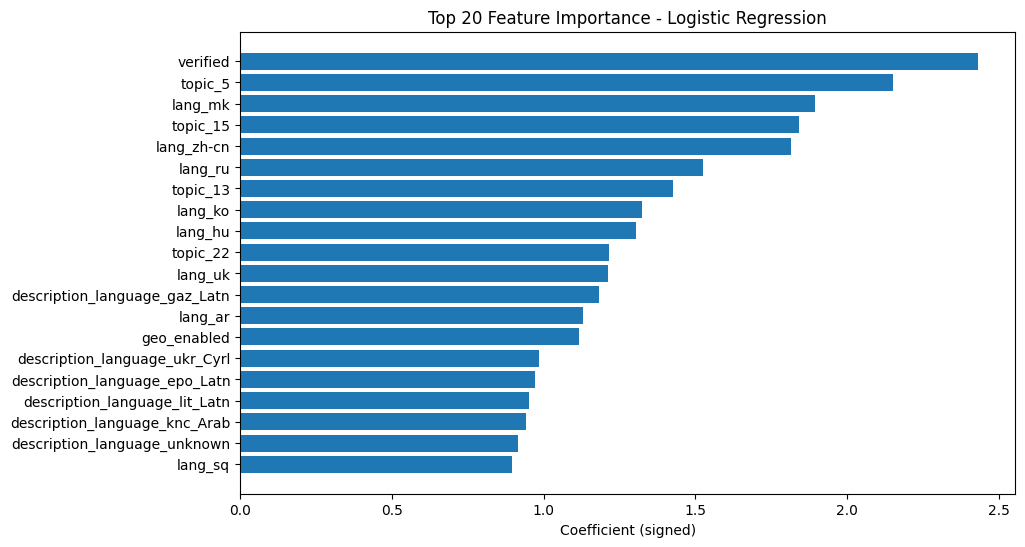

In [61]:
# feature names (topic + tabular)
feature_names = topic_dummies_train.columns.tolist() + tabular_cols

# coefficients
lr_coef = lr_bert.coef_[0]  # binary classification

# LR feature importance
lr_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(lr_coef)
}).sort_values(by='importance', ascending=False)

print("Top features for Logistic Regression:")
print(lr_feat_importance.head(10))

# plot
plt.figure(figsize=(10,6))
plt.barh(lr_feat_importance['feature'].head(20), lr_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Logistic Regression")
plt.xlabel("Coefficient (signed)")
plt.show()


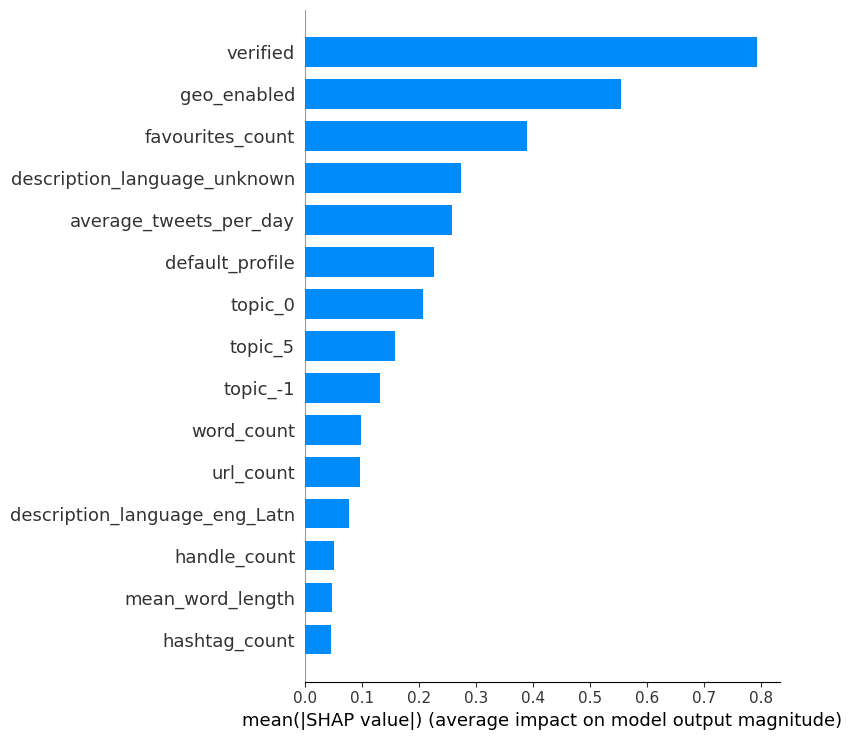

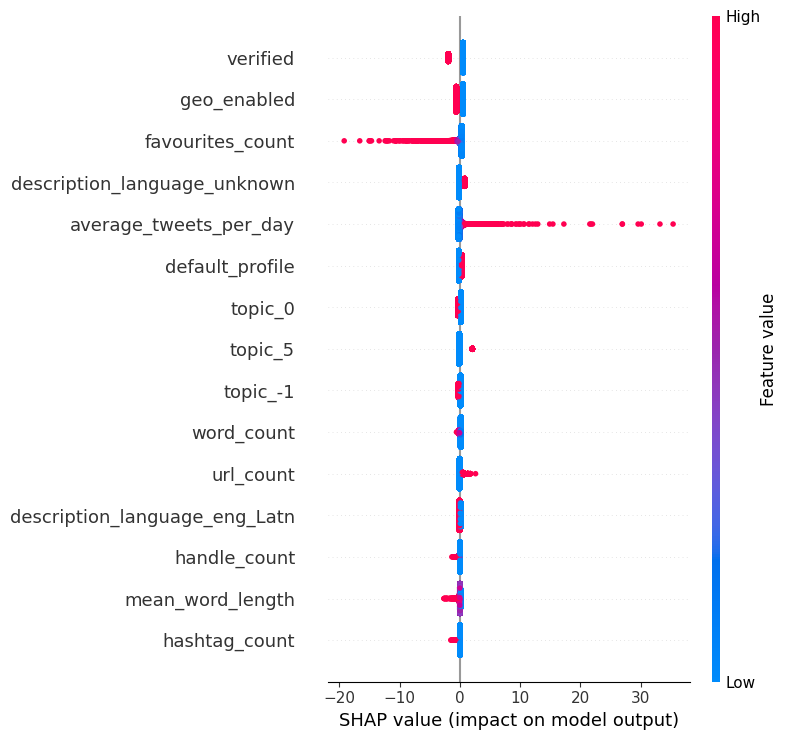

In [62]:
explainer_lr = shap.LinearExplainer(lr_bert, X_train_bert, feature_perturbation="interventional")
shap_values_lr = explainer_lr.shap_values(X_train_bert)

# Summary plot
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_lr, X_train_bert, feature_names=feature_names, plot_type="bar", max_display=15)

plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_lr, X_train_bert, feature_names=feature_names, max_display=15)

In [63]:
dt_bert = DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=42)
dt_bert.fit(X_train_bert, y_train_bert)

# predict on validation set 
y_val_pred = dt_bert.predict(X_val_bert)
y_val_prob = dt_bert.predict_proba(X_val_bert)[:, 1]

print("DT Validation Accuracy:", accuracy_score(y_val_bert, y_val_pred))
print("DT Validation ROC-AUC:", roc_auc_score(y_val_bert, y_val_prob))
print(classification_report(y_val_bert, y_val_pred))


DT Validation Accuracy: 0.8239850427350427
DT Validation ROC-AUC: 0.803506272470899
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2501
           1       0.73      0.74      0.74      1243

    accuracy                           0.82      3744
   macro avg       0.80      0.80      0.80      3744
weighted avg       0.82      0.82      0.82      3744



In [64]:
# predict on test set 
y_test_pred = dt_bert.predict(X_test_bert)
y_test_prob = dt_bert.predict_proba(X_test_bert)[:, 1]

print("DT Test Accuracy:", accuracy_score(y_test_bert, y_test_pred))
print("DT Test ROC-AUC:", roc_auc_score(y_test_bert, y_test_prob))
print(classification_report(y_test_bert, y_test_pred))

DT Test Accuracy: 0.8269230769230769
DT Test ROC-AUC: 0.8023841796128315
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      2502
           1       0.74      0.73      0.74      1242

    accuracy                           0.83      3744
   macro avg       0.81      0.80      0.80      3744
weighted avg       0.83      0.83      0.83      3744



Top features for Decision Tree:
                        feature  importance
28              followers_count    0.335235
27             favourites_count    0.122669
32       average_tweets_per_day    0.106880
33             account_age_days    0.100329
29                friends_count    0.094944
39  log_followers_friends_ratio    0.044368
35             mean_word_length    0.032891
34                   word_count    0.026265
31                     verified    0.023188
30                  geo_enabled    0.012962


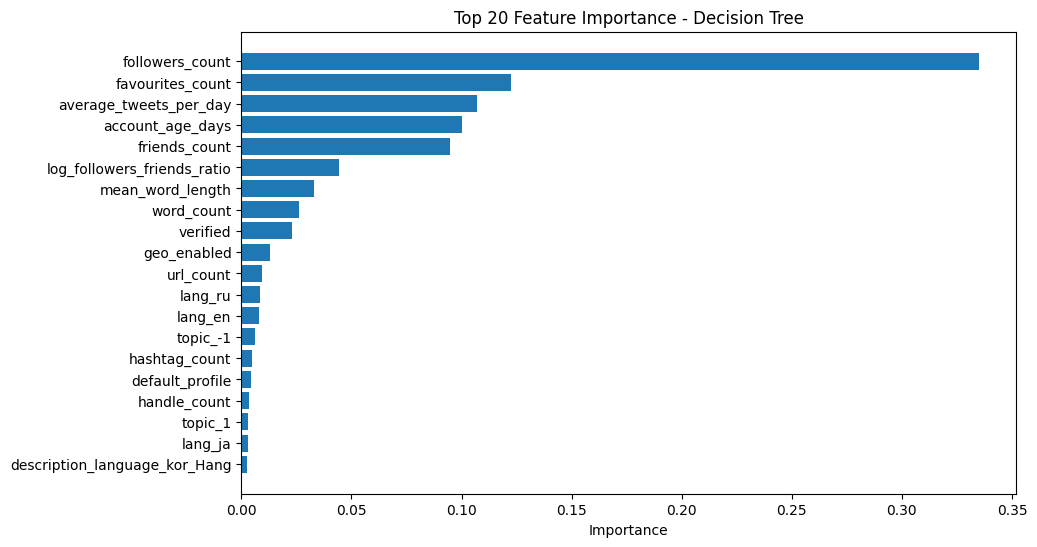

In [65]:
# DT feature importance
dt_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_bert.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top features for Decision Tree:")
print(dt_feat_importance.head(10))

# plot
plt.figure(figsize=(10,6))
plt.barh(dt_feat_importance['feature'].head(20), dt_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Decision Tree")
plt.xlabel("Importance")
plt.show()

In [66]:
X_train_df = pd.DataFrame(X_train_bert, columns=feature_names)

explainer_dt = shap.TreeExplainer(dt_bert)
shap_values_dt = explainer_dt.shap_values(X_train_df)

print(type(shap_values_dt))
if isinstance(shap_values_dt, list):
    print([s.shape for s in shap_values_dt])
else:
    print(shap_values_dt.shape)
print("X_train_df shape:", X_train_df.shape)

<class 'numpy.ndarray'>
(29950, 217, 2)
X_train_df shape: (29950, 217)


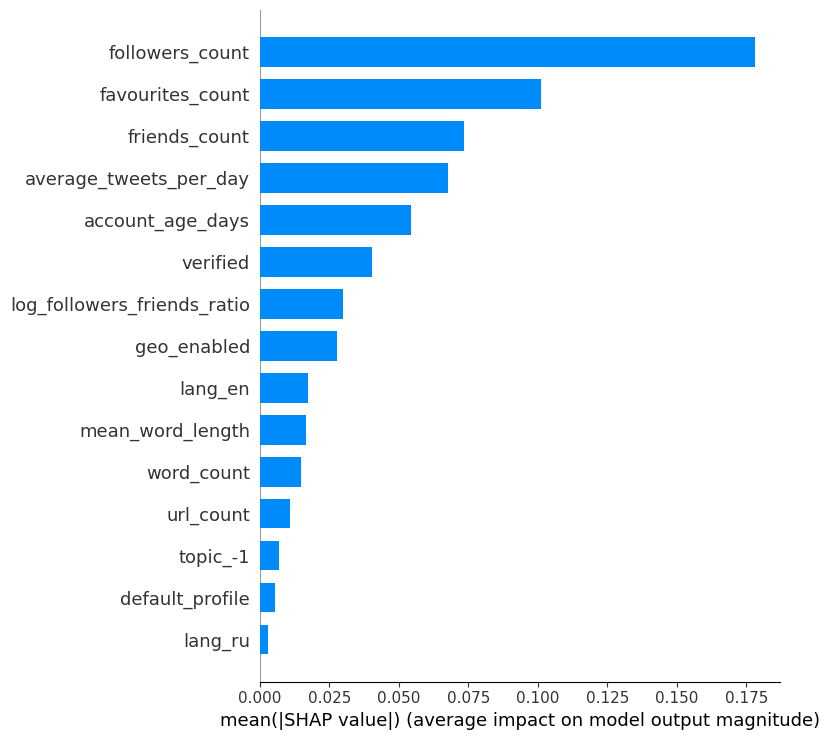

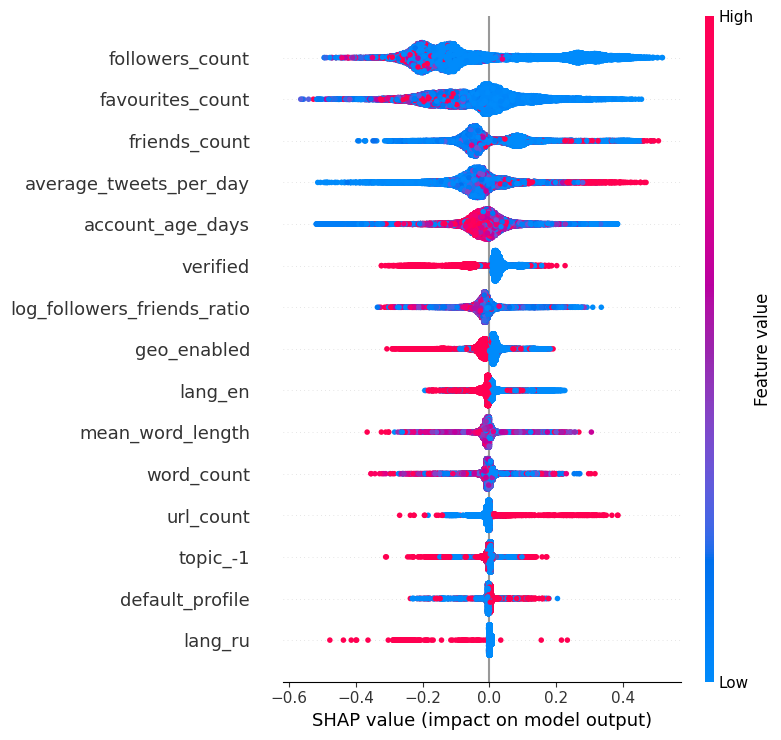

In [67]:
shap_values_class1 = shap_values_dt[:, :, 1]

# Bar summary plot
shap.summary_plot(shap_values_class1, X_train_df, plot_type="bar", max_display=15)
shap.summary_plot(shap_values_class1, X_train_df, max_display=15)

In [68]:
rf_bert = RandomForestClassifier(n_estimators=200, max_depth=None, class_weight='balanced', random_state=42)
rf_bert.fit(X_train_bert, y_train_bert)

# predict on validation set 
y_val_pred = rf_bert.predict(X_val_bert)
y_val_prob = rf_bert.predict_proba(X_val_bert)[:, 1]

print("RF Validation Accuracy:", accuracy_score(y_val_bert, y_val_pred))
print("RF Validation ROC-AUC:", roc_auc_score(y_val_bert, y_val_prob))
print(classification_report(y_val_bert, y_val_pred))


RF Validation Accuracy: 0.8723290598290598
RF Validation ROC-AUC: 0.9333032675907915
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2501
           1       0.87      0.72      0.79      1243

    accuracy                           0.87      3744
   macro avg       0.87      0.83      0.85      3744
weighted avg       0.87      0.87      0.87      3744



In [69]:
# predict on test set
y_test_pred = rf_bert.predict(X_test_bert)
y_test_prob = rf_bert.predict_proba(X_test_bert)[:, 1]

print("RF Test Accuracy:", accuracy_score(y_test_bert, y_test_pred))
print("RF Test ROC-AUC:", roc_auc_score(y_test_bert, y_test_prob))
print(classification_report(y_test_bert, y_test_pred))

RF Test Accuracy: 0.8672542735042735
RF Test ROC-AUC: 0.9251741923691322
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2502
           1       0.86      0.72      0.78      1242

    accuracy                           0.87      3744
   macro avg       0.86      0.83      0.84      3744
weighted avg       0.87      0.87      0.86      3744



Top features for Random Forest:
                        feature  importance
28              followers_count    0.144702
27             favourites_count    0.131005
29                friends_count    0.123942
32       average_tweets_per_day    0.101285
33             account_age_days    0.082940
39  log_followers_friends_ratio    0.080119
35             mean_word_length    0.044695
34                   word_count    0.040686
30                  geo_enabled    0.038929
31                     verified    0.035948


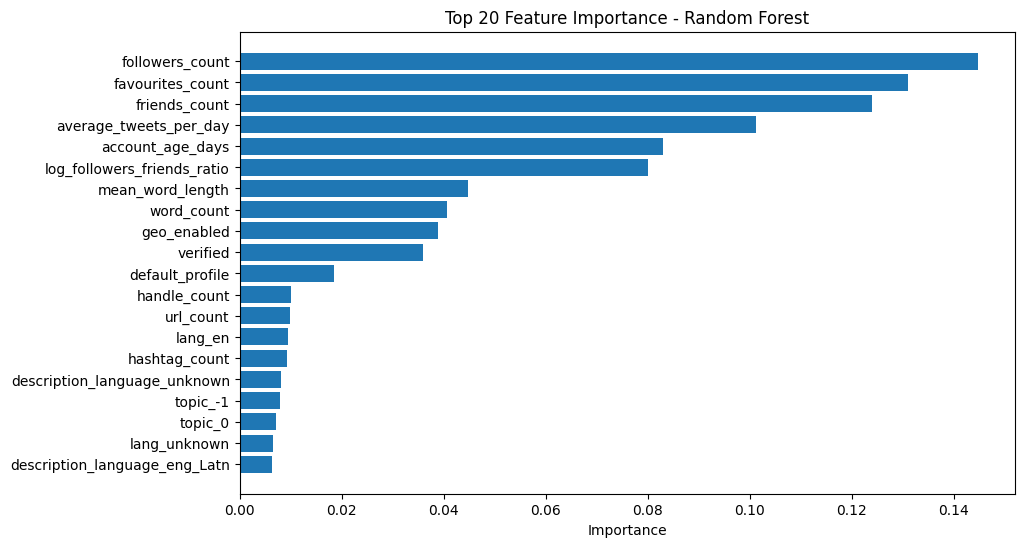

In [70]:
# RF feature importance
rf_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_bert.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top features for Random Forest:")
print(rf_feat_importance.head(10))

# plot
plt.figure(figsize=(10,6))
plt.barh(rf_feat_importance['feature'].head(20), rf_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.show()

In [71]:
# X_train_df = pd.DataFrame(X_train_bert, columns=feature_names)

# explainer_rf = shap.TreeExplainer(rf_bert)
# shap_values_rf = explainer_rf.shap_values(X_train_df)

# print(type(shap_values_rf))
# print(np.array(shap_values_rf).shape)

# shap_values_rf_class1 = shap_values_rf[:, :, 1]

# shap.summary_plot(shap_values_rf_class1, X_train_df, plot_type="bar", max_display=15)
# shap.summary_plot(shap_values_rf_class1, X_train_df, max_display=15)